# Predictive analytics for gene segment

In this notebook, we're going to explore how every each gene segment influences prediction:",
* Load samples for training and testing (**load_data.py**)",
* List all gene segment and Add new column showing the presence and absence (**read_gene.py**)",
* Training with different prediction models (**train_gene.py**)",
* Testing each gene segment with GaussianNB or Desicion Tree models (**test_gene.py**)",
* Organize and combine all prediction result of each gene segment to one single .csv file (**read_files.py**)",
* Stripplot forshowing the prediction performence of gene segment (**stripplot.py** and **Figure 1**)",
* Heatmap for each gene segment with showing presence and absence  (**heatmap.py** and **Figure 2**)"

In [4]:
import pandas as pd

df = pd.read_csv('./train_v_gene/4012V1/4012V1_v_gene.csv', sep='\t')

v_genes = df['v_gene'].unique().tolist()
print(df['v_gene'].nunique())
df1 = pd.DataFrame(v_genes, columns=['v_gene'])

for gene in df1['v_gene'].values:
    df[f'{gene}'] = df['v_gene'].apply(lambda x: 1 if x == f'{gene}' else 0)
    
print(df)
# df.to_csv('./train_v_gene/v_gene_code.csv', sep='\t', index=False)

58
           v_gene CD4/8  TRBV25-01  TRBV21-01  TRBV14  TRBV07-09  TRBV07-02  \
0       TRBV25-01   CD4          1          0       0          0          0   
1       TRBV21-01   CD4          0          1       0          0          0   
2          TRBV14   CD4          0          0       1          0          0   
3       TRBV07-09   CD4          0          0       0          1          0   
4       TRBV07-02   CD4          0          0       0          0          1   
...           ...   ...        ...        ...     ...        ...        ...   
228391  TRBV21-01   CD8          0          1       0          0          0   
228392  TRBV21-01   CD8          0          1       0          0          0   
228393  TRBV23-01   CD8          0          0       0          0          0   
228394     TRBV19   CD8          0          0       0          0          0   
228395  TRBV21-01   CD8          0          1       0          0          0   

        TRBV29-01  TRBV07-08  TRBV28  ...  TRBV1

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2


# load the v_gene data
def load_dataset(filename):
    data = pd.read_csv(filename, sep='\t')

    x_1 = data.iloc[:, 2:]
    X = x_1.values.astype(int)

    Y_1 = data.iloc[:, 1]
    le = LabelEncoder()
    le.fit(Y_1)
    y = le.transform(Y_1)
    
    return X, y


# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')  # two possibilities: chi2, mutual_info_classif
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs


# load the dataset
X, y = load_dataset('./train_v_gene/4012V1/4012V1_code.csv')
# split into train and test.txt sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# feature selection
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)

# machine learning model pipeline
model_pipeline = [LogisticRegression(solver='liblinear'), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]
model_list = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'GaussianNB']  # 'Random Forest', SVC(kernel='linear'),

acc_list = []
auc_list = []
cm_list = []
fpr_list = []
tpr_list = []
y_known = []
pred = []
prob = []

for model in model_pipeline:
    model.fit(X_train_fs, y_train)
    y_pred = model.predict(X_test_fs)
    y_prob = model.predict_proba(X_test_fs)

    acc_list.append(accuracy_score(y_test, y_pred))
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_prob[:, 1])
    fpr_list.append(false_positive_rate)
    tpr_list.append(true_positive_rate)
    auc_list.append(round(roc_auc_score(y_test, y_prob[:, 1]), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    tp, tn, fn, fp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    cd4_num = tp + fn
    y_known.append(y_test)
    pred.append(y_pred)
    p_estimated = cd4_num / len(y_test)
    print(p_estimated)
    list_1 = y_prob[:, 0].tolist()
    prob.append(list_1)

# model evaluation
# plot confusion matrix
fig = plt.figure(figsize=(18, 10))
for n in range(len(cm_list)):
    con_matrix = cm_list[n]
    model = model_list[n]
    sub = fig.add_subplot(2, 3, n + 1).set_title(model)
    cm_plot = sns.heatmap(con_matrix, annot=True, cmap='Blues', fmt='g')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')
plt.show()

# plot ROC curves
fig = plt.figure(figsize=(18, 10))
for n in range(len(acc_list)):
    auc_value = auc_list[n]
    fpr = fpr_list[n]
    tpr = tpr_list[n]
    model = model_list[n]
    sub = fig.add_subplot(2, 3, n + 1).set_title(model)
    plt.plot(fpr, tpr, label="AUC=" + str(auc_value))
    plt.xlabel('false Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
plt.show()

# violinplot
fig = plt.figure(figsize=(18, 10))
for n in range(len(y_known)):
    # add stripplot
    # ax = sns.stripplot(x='cells', y='probability', data=df, color="orange", jitter=0.2, size=2.5)
    model = model_list[n]
    sub = fig.add_subplot(2, 3, n + 1).set_title(model)
    ax = sns.violinplot(x=y_known[n], y=prob[n])
    ax.set_xticklabels(labels=['CD4', 'CD8'])
    # add label & title
    plt.ylabel('Probability for CD4')
    plt.xlabel('Actual Cells')
    plt.title("Likelihood for CD4", loc="left")
plt.show()

# Accuracy and AUC
result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
print(result_df)

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder


# load the dataset
def load_dataset(df):
    x_1 = df.iloc[:, 1: 2]
    X = x_1.values.astype(int)

    Y_1 = df.iloc[:, 0]
    le = LabelEncoder()
    le.fit(Y_1)
    y = le.transform(Y_1)

    gene = df.columns.values[1]
    
    return X, y, gene

# load the dataset
data = pd.read_csv('./train_v_gene/4012V1/4012V1_code.csv', sep='\t')
for i in range(2, 62): # number of v_gene segment
    ' print(i)
    df = data.iloc[:, [1, i]]
    X, y, gene = load_dataset(df)
    # split into train and test.txt sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # fit the model
    model = GaussianNB()  # LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    # evaluate the model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    # print(y_prob[:, 0])
    result_df = pd.DataFrame({'Cells': y_test, 'y_predict': y_pred, 'y_prob_cd4': y_prob[:, 0], 'gene': f'{gene}'})
    p = os.path.join('E:/Document/28_03_v_gene/train_v_gene/4012V1/GaussianNB/', 'prob_{}.csv'.format(gene.upper()))
    result_df.to_csv(p, sep='\t', index=False)

In [ ]:
import pandas as pd
import glob
import os

os.chdir('./train_v_gene/4012V1/GaussianNB/')
data_files = glob.glob('prob_*.csv')

final_df = pd.DataFrame()
for file in data_files:
    file_name = file[:file.index(".")].split("_")
    gene = file_name[1]  # + '_' + file_name[2]

    df = pd.read_csv(file, sep='\t')
    df[['Cells']] = df[['Cells']].replace({1: 'CD8', 0: 'CD4'})
    df['gene'] = f'{gene}'
    df['y_prob_cd4'] = pd.to_numeric(df['y_prob_cd4'])

    final_df = final_df.append(df, ignore_index=True)
    final_df.to_csv('./prob.csv', sep='\t', index=False)

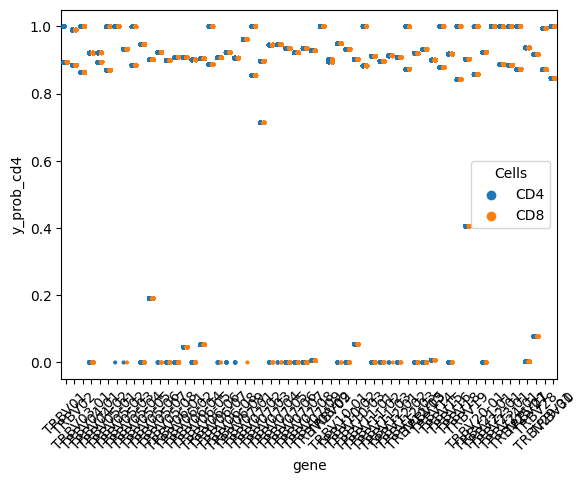

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = pd.read_csv('./train_v_gene/4012V1/GaussianNB/prob.csv', sep='\t')

sns.stripplot(data=data, x="gene", y="y_prob_cd4", hue="Cells", size=3, dodge=True)
plt.xticks(rotation=45)
plt.show()

C:\Users\Jingyun\AppData\Local\Temp\ipykernel_7148\2055196123.py:42: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x_test = np.fromstring(X_test.tobytes(), dtype=int)


Text(0.0, 1.0, 'Heatmap for TRBV07-09')

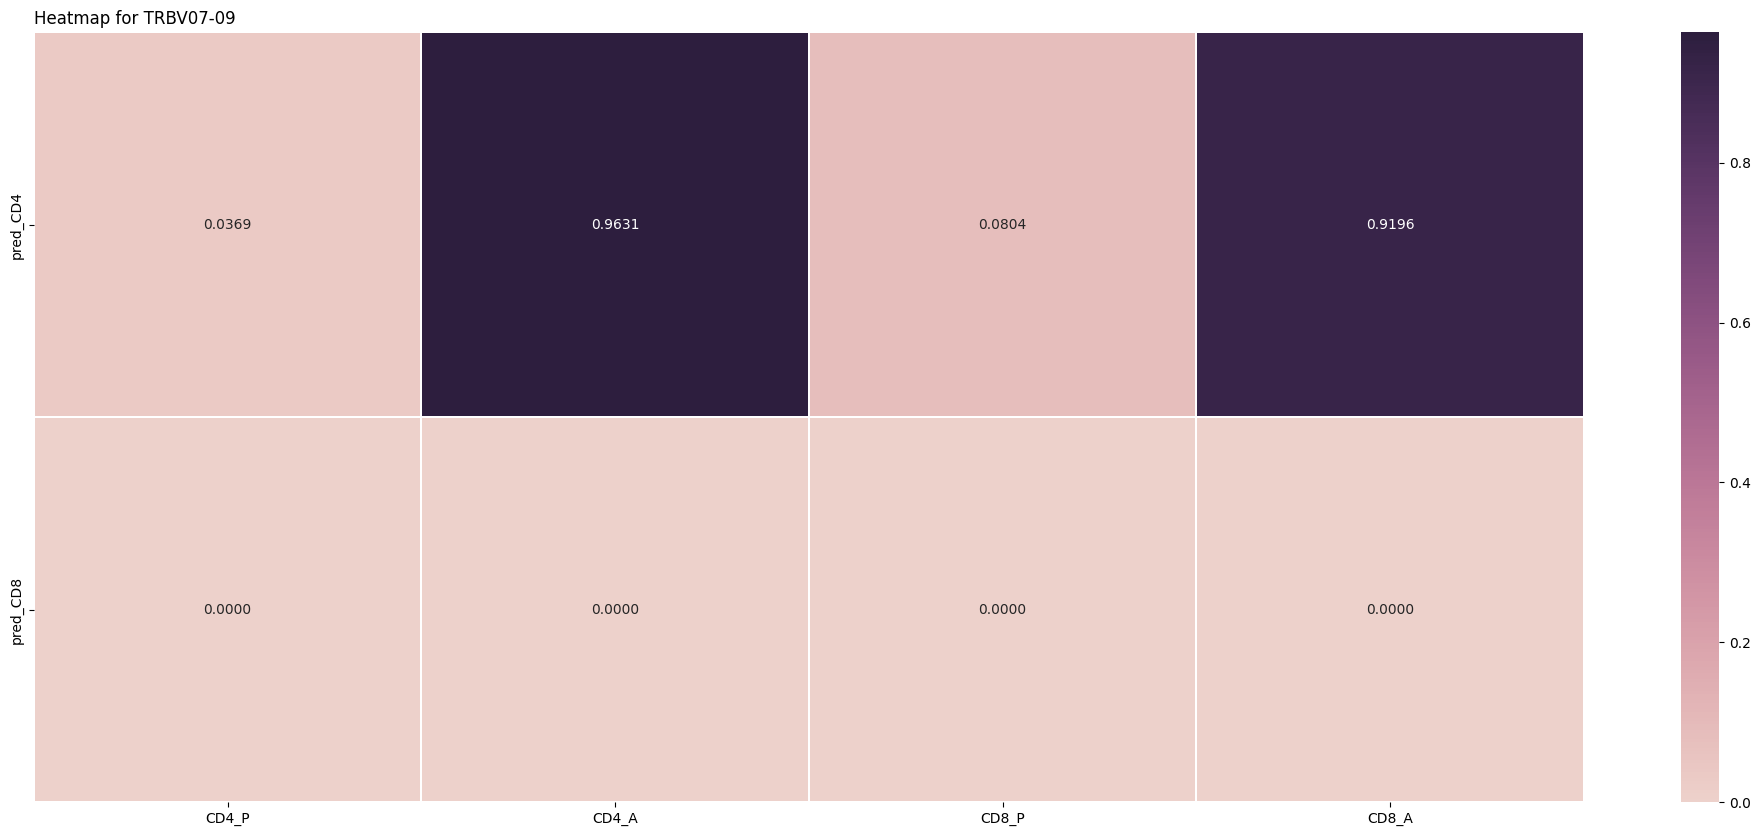

In [8]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder


# load the dataset
def load_dataset(df):
    x_1 = df.iloc[:, 1: 2]
    X = x_1.values.astype(int)

    Y_1 = df.iloc[:, 0]
    le = LabelEncoder()
    le.fit(Y_1)
    y = le.transform(Y_1)

    gene = df.columns.values[1]

    return X, y, gene


# load the dataset
data = pd.read_csv('E:/Document/28_03_v_gene/train_v_gene/4012V1/4012V1_code.csv', sep='\t')

# for i in range(2, 62):
df = data[['CD4/8', 'TRBV07-09']]
X, y, gene = load_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# fit the model
model = DecisionTreeClassifier()  
model.fit(X_train, y_train)
# evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
# print(y_prob[:, 0])
x_test = np.fromstring(X_test.tobytes(), dtype=int)

result_df = pd.DataFrame({'Cells': y_test, 'y_predict': y_pred, 'y_prob_cd4': y_prob[:, 0], 'gene': x_test})  # 'y_prob_cd4': y_prob[:, 0],
# p = os.path.join('E:/Document/28_03_v_gene/train_v_gene/Decision_Tree', 'prob_{}.csv'.format(gene.upper()))
# result_df.to_csv('E:/Document/28_03_v_gene/train_v_gene/test_TRBV07-01.csv', sep='\t', index=False)

result_df[['Cells']] = result_df[['Cells']].replace({1: 'CD8', 0: 'CD4'})
result_df[['gene']] = result_df[['gene']].replace({1: 'present', 0: 'absent'})
result_df[['y_predict']] = result_df[['y_predict']].replace({1: 'CD8', 0: 'CD4'})

model = ({
    'CD4_P': [len(result_df[(result_df['gene'] == 'present') & (result_df['Cells'] == 'CD4') & (result_df['y_predict'] == 'CD4')]) / len(result_df[(result_df['Cells'] == 'CD4')]),
              len(result_df[(result_df['gene'] == 'present') & (result_df['Cells'] == 'CD4') & (result_df['y_predict'] == 'CD8')]) / len(result_df[(result_df['Cells'] == 'CD4')])],
    'CD4_A': [len(result_df[(result_df['gene'] == 'absent') & (result_df['Cells'] == 'CD4') & (result_df['y_predict'] == 'CD4')]) / len(result_df[(result_df['Cells'] == 'CD4')]),
              len(result_df[(result_df['gene'] == 'absent') & (result_df['Cells'] == 'CD4') & (result_df['y_predict'] == 'CD8')]) / len(result_df[(result_df['Cells'] == 'CD4')])],
    'CD8_P': [len(result_df[(result_df['gene'] == 'present') & (result_df['Cells'] == 'CD8') & (result_df['y_predict'] == 'CD4')]) / len(result_df[(result_df['Cells'] == 'CD8')]),
              len(result_df[(result_df['gene'] == 'present') & (result_df['Cells'] == 'CD8') & (result_df['y_predict'] == 'CD8')]) / len(result_df[(result_df['Cells'] == 'CD8')])],
    'CD8_A': [len(result_df[(result_df['gene'] == 'absent') & (result_df['Cells'] == 'CD8') & (result_df['y_predict'] == 'CD4')]) / len(result_df[(result_df['Cells'] == 'CD8')]),
              len(result_df[(result_df['gene'] == 'absent') & (result_df['Cells'] == 'CD8') & (result_df['y_predict'] == 'CD8')]) / len(result_df[(result_df['Cells'] == 'CD8')])]
              })
# print(len(result_df[(result_df['gene'] == 'present') & (result_df['Cells'] == 'CD4') & (result_df['y_predict'] == 'CD8')]))
# print(len(result_df[(result_df['gene'] == 'present') & (result_df['Cells'] == 'CD8') & (result_df['y_predict'] == 'CD8')]))
# print(len(result_df[(result_df['Cells'] == 'CD4')]))
# print(len(result_df[(result_df['Cells'] == 'CD8')]))

index_labels = ['pred_CD4', 'pred_CD8']
test_df = pd.DataFrame(model, index=index_labels)
ax = sns.heatmap(test_df, annot=True, fmt='.4f', linewidths=.3, cmap=sns.cubehelix_palette(as_cmap=True))
ax.figure.set_size_inches(25, 10)
plt.title('Heatmap for ' + f'{gene}', loc="left")

# p = os.path.join('E:/Document/28_03_v_gene/train_v_gene/4012V1/figures/Decison_Tree/', 'heatmap_for_{}.png'.format(gene.upper()))
# plt.savefig(p)